In [6]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        print('CLASS')
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        print('REG')
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


REG


c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 2s - 17ms/step - loss: 2.6385 - val_loss: 0.5054
Epoch 2/1000
136/136 - 1s - 4ms/step - loss: 0.4199 - val_loss: 0.3410
Epoch 3/1000
136/136 - 1s - 5ms/step - loss: 0.2763 - val_loss: 0.3529
Epoch 4/1000
136/136 - 1s - 6ms/step - loss: 0.2196 - val_loss: 0.3673
Epoch 5/1000
136/136 - 1s - 5ms/step - loss: 0.1830 - val_loss: 0.3869
Epoch 6/1000
136/136 - 1s - 5ms/step - loss: 0.1545 - val_loss: 0.3939
Epoch 7/1000
136/136 - 1s - 5ms/step - loss: 0.1326 - val_loss: 0.4223
Epoch 8/1000
136/136 - 1s - 5ms/step - loss: 0.1227 - val_loss: 0.4106
Epoch 9/1000
136/136 - 1s - 4ms/step - loss: 0.1069 - val_loss: 0.4285
Epoch 10/1000
136/136 - 1s - 4ms/step - loss: 0.1042 - val_loss: 0.4290
Epoch 11/1000
136/136 - 1s - 4ms/step - loss: 0.0919 - val_loss: 0.4225
Epoch 12/1000
136/136 - 1s - 4ms/step - loss: 0.0863 - val_loss: 0.4092
Epoch 12: early stopping
Epoch 1/1000
136/136 - 2s - 17ms/step - loss: 2.0644 - val_loss: 0.3826
Epoch 2/1000
136/136 - 1s - 4ms/step - loss: 0.

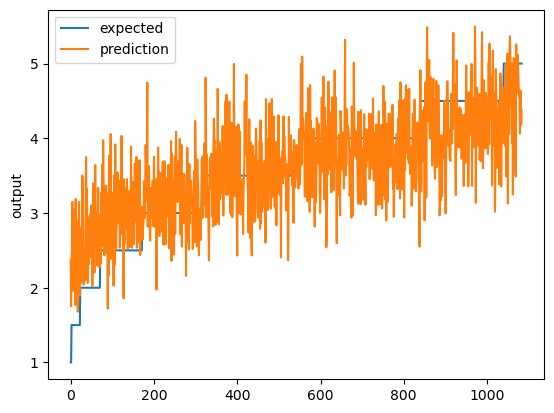

In [7]:
# Author: Nicolas Gugliemo 
# Date: 9/16/2024
# Project: Project 1 Yelp Business Rating Prediction using Tensorflow
# Goal: Predict Business's stars rating... 
# (1) Report the RMSE and plot the lift chart of the BEST neural network model you have obtained.
# (2) Choose 5 arbitrary businesses from your test data (preferably from different categories). Show
#     the names, the true star ratings, and the predicted ratings (from your best model) of those
#     businesses.
# Type: Regression (Expect a number)
# Data Restrictions:
# (1) Businesses with at least 20 reviews
# (2) At least 10K businesses in set
# (3) Business = busisness_id, stars, review_count, categories
# (4) Review   = busisness_id, stars, text 
'''Grading:  (5 pts) Do train/test split.
 (5 pts) Remove all the businesses with less than 20 reviews.
 (10 pts) Use TF-IDF to do feature extraction from review texts.
 (10 pts) Use EarlyStopping when using Tensorflow.
 (30 pts) Change the following hyperparameters to record how they affect performance in your report.
Tabulate your findings.
o Activation: relu, sigmoid, tanh
o Layers and neuron counts
o Optimizer: adam and sgd
 (10 pts) Report the RMSE of the BEST regression model you obtained
 (10 pts) Plot the lift chart on test data of the BEST regression model you obtained
 (5 pts) Show names and the true ratings of 5 businesses, and their predicted ratings
 (5 pts) Your report includes the following sections:
o Problem Statement
o Methodology
o Experimental Results and Analysis
o Task Division and Project Reflection
 (10 pts) Additional features
'''
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

# Set path and preprocess for functions
path = "./yelp_dataset/"
preprocess = True

#Set paths for JSON
review_Path = os.path.join(path,"yelp_academic_dataset_review.json")
business_Path = os.path.join(path,"yelp_academic_dataset_business.json")

# Read JSON data and drop businesses with less than 20 reviews
review_df = pd.read_json(review_Path, lines=True, nrows = 100000)
all_business_df = pd.read_json(business_Path, lines=True, nrows = 100000)
business_df = all_business_df[all_business_df['review_count'] >= 20]

#You may use the following code to group ALL the reviews by each business and create a new
#dataframe, where each line is a business with all its reviews aggregated together. From there,
#you then use tfidfVectorzier to obtain TFIDF representation for each business.
df_review_agg = review_df.groupby('business_id')['text'].sum()
df_ready_to_be_sent_to_sklearn = pd.DataFrame({'business_id': df_review_agg.index,
                                               'all_reviews': df_review_agg.values,})

#Create table with ID, stars, and all reviews in one table then change 'stars' since this is already a col on tfidf
business_subset = business_df[['business_id', 'stars']]
review_subset = df_ready_to_be_sent_to_sklearn[['business_id', 'all_reviews']]
merged_df = pd.merge(business_subset, df_ready_to_be_sent_to_sklearn, on='business_id', how='inner')
merged_df.rename(columns={'stars': 'stars_for_model'}, inplace=True)

# Initialize the tfidf Vectorizer and set max features and stop words
tfidf = TfidfVectorizer(max_features=4000,stop_words="english")

# Transform all_reviews and turn into a matrix
tfidf_matrix = tfidf.fit_transform(merged_df['all_reviews'])

# Turn the matrix into a dataframe where the cols are all the words. Then add the stars into the dataframe for model to use and use to_xy for tensorflow to read
tfidf_df = pd.DataFrame(data = tfidf_matrix.toarray(), columns = tfidf.get_feature_names_out())
tfidf_df = pd.concat([merged_df['stars_for_model'], tfidf_df] , axis=1)
x,y = to_xy(tfidf_df,'stars_for_model')

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

#Run the model 5 times to ensure best model is found
i = 0
while (i<5):
    model = Sequential()
    model.add(Dense(100, input_dim=x.shape[1], activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(50, input_dim=x.shape[1], activation='relu')) 
    model.add(Dropout(0.1))
    model.add(Dense(25, input_dim=x.shape[1], activation='relu')) 
    model.add(Dense(1, activation='linear'))

    adam = optimizers.Adam(learning_rate=0.001, beta_1=0.999, beta_2=0.999, epsilon=None, amsgrad=False)
    model.compile(loss='mean_squared_error', optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto')
    checkpointer = ModelCheckpoint(filepath="dnn/yelp.keras", verbose=0, save_best_only=True) # save best model

    # batch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32.
    model.fit(x_train,y_train,validation_data=(x_test,y_test), batch_size= 32, callbacks=[monitor,checkpointer],verbose=2,epochs=1000)
    i = i+1

model.load_weights('dnn/yelp.keras') # load weights from best model

# Predict and measure RMSE
pred = model.predict(x_test)
print(pred)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))


# Plot the chart
chart_regression(pred.flatten(),y_test)


REG
Epoch 1/1000


c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 2s - 16ms/step - loss: 2.7134 - val_loss: 0.4294
Epoch 2/1000
136/136 - 1s - 4ms/step - loss: 0.5127 - val_loss: 0.3539
Epoch 3/1000
136/136 - 1s - 4ms/step - loss: 0.3828 - val_loss: 0.3784
Epoch 4/1000
136/136 - 1s - 4ms/step - loss: 0.3382 - val_loss: 0.3597
Epoch 5/1000
136/136 - 0s - 4ms/step - loss: 0.2960 - val_loss: 0.3654
Epoch 6/1000
136/136 - 0s - 3ms/step - loss: 0.2823 - val_loss: 0.3806
Epoch 7/1000
136/136 - 0s - 4ms/step - loss: 0.2481 - val_loss: 0.3825
Epoch 8/1000
136/136 - 1s - 4ms/step - loss: 0.2361 - val_loss: 0.3988
Epoch 9/1000
136/136 - 1s - 4ms/step - loss: 0.2213 - val_loss: 0.3940
Epoch 10/1000
136/136 - 0s - 3ms/step - loss: 0.2174 - val_loss: 0.4052
Epoch 11/1000
136/136 - 0s - 3ms/step - loss: 0.2025 - val_loss: 0.4017
Epoch 12/1000
136/136 - 0s - 4ms/step - loss: 0.1872 - val_loss: 0.3956
Epoch 12: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[3.240941 ]
 [3.3325298]
 [2.4837244]
 ...
 [4.6143055]
 [3.1585803]
 [3.923369 ]]
Score (RM

c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 1s - 6ms/step - loss: 1.4013 - val_loss: 0.5929
Epoch 2/1000
136/136 - 0s - 2ms/step - loss: 0.7652 - val_loss: 0.5405
Epoch 3/1000
136/136 - 0s - 2ms/step - loss: 0.6557 - val_loss: 0.4816
Epoch 4/1000
136/136 - 0s - 2ms/step - loss: 0.5652 - val_loss: 0.4401
Epoch 5/1000
136/136 - 0s - 2ms/step - loss: 0.4818 - val_loss: 0.3838
Epoch 6/1000
136/136 - 0s - 3ms/step - loss: 0.4240 - val_loss: 0.4429
Epoch 7/1000
136/136 - 0s - 2ms/step - loss: 0.4117 - val_loss: 0.3872
Epoch 8/1000
136/136 - 0s - 3ms/step - loss: 0.3770 - val_loss: 0.3245
Epoch 9/1000
136/136 - 0s - 2ms/step - loss: 0.3585 - val_loss: 0.5038
Epoch 10/1000
136/136 - 0s - 3ms/step - loss: 0.3553 - val_loss: 0.3227
Epoch 11/1000
136/136 - 0s - 2ms/step - loss: 0.3418 - val_loss: 0.3015
Epoch 12/1000
136/136 - 1s - 5ms/step - loss: 0.3244 - val_loss: 0.3203
Epoch 13/1000
136/136 - 0s - 3ms/step - loss: 0.3058 - val_loss: 0.2974
Epoch 14/1000
136/136 - 0s - 3ms/step - loss: 0.2973 - val_loss: 0.3004
Epoch 15/1000


c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 3s - 24ms/step - loss: 2.1117 - val_loss: 0.4062
Epoch 2/1000
136/136 - 1s - 5ms/step - loss: 0.4603 - val_loss: 0.3567
Epoch 3/1000
136/136 - 1s - 6ms/step - loss: 0.3620 - val_loss: 0.3562
Epoch 4/1000
136/136 - 1s - 5ms/step - loss: 0.2925 - val_loss: 0.3838
Epoch 5/1000
136/136 - 1s - 5ms/step - loss: 0.2586 - val_loss: 0.4175
Epoch 6/1000
136/136 - 1s - 5ms/step - loss: 0.2433 - val_loss: 0.4047
Epoch 7/1000
136/136 - 1s - 5ms/step - loss: 0.2202 - val_loss: 0.3903
Epoch 8/1000
136/136 - 1s - 5ms/step - loss: 0.1923 - val_loss: 0.4015
Epoch 9/1000
136/136 - 1s - 6ms/step - loss: 0.1821 - val_loss: 0.4260
Epoch 10/1000
136/136 - 1s - 5ms/step - loss: 0.1775 - val_loss: 0.3990
Epoch 11/1000
136/136 - 1s - 5ms/step - loss: 0.1615 - val_loss: 0.4069
Epoch 12/1000
136/136 - 1s - 6ms/step - loss: 0.1550 - val_loss: 0.3949
Epoch 12: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[[2.8419075]
 [3.4775743]
 [2.2674155]
 ...
 [4.786136 ]
 [3.5055134]
 [4.0407567]]
Score (RM

c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 1s - 7ms/step - loss: 1.4976 - val_loss: 0.6192
Epoch 2/1000
136/136 - 0s - 3ms/step - loss: 0.7380 - val_loss: 0.5732
Epoch 3/1000
136/136 - 0s - 3ms/step - loss: 0.6624 - val_loss: 0.5229
Epoch 4/1000
136/136 - 1s - 5ms/step - loss: 0.5950 - val_loss: 0.4665
Epoch 5/1000
136/136 - 0s - 3ms/step - loss: 0.5051 - val_loss: 0.3918
Epoch 6/1000
136/136 - 0s - 3ms/step - loss: 0.4403 - val_loss: 0.3427
Epoch 7/1000
136/136 - 0s - 3ms/step - loss: 0.4173 - val_loss: 0.3258
Epoch 8/1000
136/136 - 0s - 3ms/step - loss: 0.3888 - val_loss: 0.3415
Epoch 9/1000
136/136 - 0s - 2ms/step - loss: 0.3651 - val_loss: 0.3613
Epoch 10/1000
136/136 - 0s - 3ms/step - loss: 0.3583 - val_loss: 0.3065
Epoch 11/1000
136/136 - 0s - 3ms/step - loss: 0.3317 - val_loss: 0.3383
Epoch 12/1000
136/136 - 0s - 3ms/step - loss: 0.3188 - val_loss: 0.3010
Epoch 13/1000
136/136 - 0s - 3ms/step - loss: 0.3154 - val_loss: 0.2956
Epoch 14/1000
136/136 - 0s - 3ms/step - loss: 0.3105 - val_loss: 0.3615
Epoch 15/1000


c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 3s - 20ms/step - loss: 2.1358 - val_loss: 0.3751
Epoch 2/1000
136/136 - 1s - 5ms/step - loss: 0.3519 - val_loss: 0.3511
Epoch 3/1000
136/136 - 1s - 5ms/step - loss: 0.2563 - val_loss: 0.3409
Epoch 4/1000
136/136 - 1s - 5ms/step - loss: 0.2018 - val_loss: 0.3630
Epoch 5/1000
136/136 - 1s - 5ms/step - loss: 0.1767 - val_loss: 0.3825
Epoch 6/1000
136/136 - 1s - 4ms/step - loss: 0.1568 - val_loss: 0.3974
Epoch 7/1000
136/136 - 1s - 4ms/step - loss: 0.1338 - val_loss: 0.4020
Epoch 8/1000
136/136 - 1s - 4ms/step - loss: 0.1216 - val_loss: 0.3926
Epoch 9/1000
136/136 - 1s - 4ms/step - loss: 0.1120 - val_loss: 0.3952
Epoch 10/1000
136/136 - 1s - 4ms/step - loss: 0.1000 - val_loss: 0.3993
Epoch 11/1000
136/136 - 1s - 4ms/step - loss: 0.0920 - val_loss: 0.4013
Epoch 12/1000
136/136 - 1s - 4ms/step - loss: 0.0930 - val_loss: 0.3956
Epoch 13/1000
136/136 - 1s - 4ms/step - loss: 0.0872 - val_loss: 0.3962
Epoch 13: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[2.8670835]
 [3.3461

c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 1s - 7ms/step - loss: 1.4198 - val_loss: 0.6205
Epoch 2/1000
136/136 - 0s - 3ms/step - loss: 0.6881 - val_loss: 0.6480
Epoch 3/1000
136/136 - 0s - 3ms/step - loss: 0.6315 - val_loss: 0.5185
Epoch 4/1000
136/136 - 0s - 3ms/step - loss: 0.5555 - val_loss: 0.4583
Epoch 5/1000
136/136 - 0s - 3ms/step - loss: 0.4642 - val_loss: 0.4710
Epoch 6/1000
136/136 - 0s - 3ms/step - loss: 0.4129 - val_loss: 0.3475
Epoch 7/1000
136/136 - 0s - 3ms/step - loss: 0.3777 - val_loss: 0.3260
Epoch 8/1000
136/136 - 0s - 3ms/step - loss: 0.3564 - val_loss: 0.3200
Epoch 9/1000
136/136 - 0s - 3ms/step - loss: 0.3310 - val_loss: 0.3617
Epoch 10/1000
136/136 - 0s - 3ms/step - loss: 0.3189 - val_loss: 0.3044
Epoch 11/1000
136/136 - 0s - 3ms/step - loss: 0.3048 - val_loss: 0.3061
Epoch 12/1000
136/136 - 0s - 3ms/step - loss: 0.2957 - val_loss: 0.3068
Epoch 13/1000
136/136 - 0s - 3ms/step - loss: 0.2927 - val_loss: 0.3081
Epoch 14/1000
136/136 - 0s - 3ms/step - loss: 0.2794 - val_loss: 0.2994
Epoch 15/1000


c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 3s - 20ms/step - loss: 5.2801 - val_loss: 0.8873
Epoch 2/1000
136/136 - 0s - 4ms/step - loss: 0.8887 - val_loss: 0.6479
Epoch 3/1000
136/136 - 1s - 4ms/step - loss: 0.8331 - val_loss: 0.6459
Epoch 4/1000
136/136 - 1s - 4ms/step - loss: 0.8292 - val_loss: 0.6449
Epoch 5/1000
136/136 - 0s - 4ms/step - loss: 0.8351 - val_loss: 0.6435
Epoch 6/1000
136/136 - 0s - 4ms/step - loss: 0.8369 - val_loss: 0.6435
Epoch 7/1000
136/136 - 1s - 4ms/step - loss: 0.8364 - val_loss: 0.6413
Epoch 8/1000
136/136 - 1s - 4ms/step - loss: 0.8192 - val_loss: 0.6369
Epoch 9/1000
136/136 - 0s - 3ms/step - loss: 0.8101 - val_loss: 0.6287
Epoch 10/1000
136/136 - 0s - 3ms/step - loss: 0.7843 - val_loss: 0.5909
Epoch 11/1000
136/136 - 1s - 4ms/step - loss: 0.6979 - val_loss: 0.4587
Epoch 12/1000
136/136 - 0s - 4ms/step - loss: 0.5219 - val_loss: 0.3332
Epoch 13/1000
136/136 - 1s - 6ms/step - loss: 0.4272 - val_loss: 0.3091
Epoch 14/1000
136/136 - 1s - 8ms/step - loss: 0.3908 - val_loss: 0.3018
Epoch 15/1000

c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 1s - 6ms/step - loss: 1.0058 - val_loss: 0.6493
Epoch 2/1000
136/136 - 0s - 2ms/step - loss: 0.7839 - val_loss: 0.6456
Epoch 3/1000
136/136 - 0s - 2ms/step - loss: 0.7826 - val_loss: 0.6476
Epoch 4/1000
136/136 - 0s - 2ms/step - loss: 0.7620 - val_loss: 0.6500
Epoch 5/1000
136/136 - 0s - 4ms/step - loss: 0.7606 - val_loss: 0.6472
Epoch 6/1000
136/136 - 0s - 3ms/step - loss: 0.7637 - val_loss: 0.6458
Epoch 7/1000
136/136 - 0s - 2ms/step - loss: 0.7465 - val_loss: 0.6467
Epoch 8/1000
136/136 - 0s - 3ms/step - loss: 0.7531 - val_loss: 0.6456
Epoch 9/1000
136/136 - 0s - 3ms/step - loss: 0.7411 - val_loss: 0.6553
Epoch 10/1000
136/136 - 1s - 5ms/step - loss: 0.7458 - val_loss: 0.6484
Epoch 11/1000
136/136 - 0s - 3ms/step - loss: 0.7422 - val_loss: 0.6462
Epoch 12/1000
136/136 - 0s - 3ms/step - loss: 0.7355 - val_loss: 0.6462
Epoch 12: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[[3.6103776]
 [3.6097312]
 [3.61148  ]
 ...
 [3.6102672]
 [3.6110852]
 [3.6114082]]
Score (RMS

c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 3s - 19ms/step - loss: 4.5965 - val_loss: 0.9982
Epoch 2/1000
136/136 - 1s - 6ms/step - loss: 0.9114 - val_loss: 0.6591
Epoch 3/1000
136/136 - 1s - 8ms/step - loss: 0.8237 - val_loss: 0.6474
Epoch 4/1000
136/136 - 1s - 6ms/step - loss: 0.8002 - val_loss: 0.6467
Epoch 5/1000
136/136 - 1s - 7ms/step - loss: 0.8427 - val_loss: 0.6452
Epoch 6/1000
136/136 - 1s - 5ms/step - loss: 0.8142 - val_loss: 0.6457
Epoch 7/1000
136/136 - 1s - 5ms/step - loss: 0.8116 - val_loss: 0.6470
Epoch 8/1000
136/136 - 1s - 6ms/step - loss: 0.8227 - val_loss: 0.6492
Epoch 9/1000
136/136 - 1s - 6ms/step - loss: 0.8205 - val_loss: 0.6440
Epoch 10/1000
136/136 - 1s - 9ms/step - loss: 0.8193 - val_loss: 0.6450
Epoch 11/1000
136/136 - 1s - 5ms/step - loss: 0.8171 - val_loss: 0.6431
Epoch 12/1000
136/136 - 1s - 6ms/step - loss: 0.7910 - val_loss: 0.6394
Epoch 13/1000
136/136 - 1s - 7ms/step - loss: 0.8055 - val_loss: 0.6288
Epoch 14/1000
136/136 - 1s - 5ms/step - loss: 0.7156 - val_loss: 0.4651
Epoch 15/1000

c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 1s - 7ms/step - loss: 1.2506 - val_loss: 0.6461
Epoch 2/1000
136/136 - 0s - 3ms/step - loss: 0.8079 - val_loss: 0.6456
Epoch 3/1000
136/136 - 0s - 3ms/step - loss: 0.7836 - val_loss: 0.6461
Epoch 4/1000
136/136 - 0s - 3ms/step - loss: 0.7748 - val_loss: 0.6461
Epoch 5/1000
136/136 - 0s - 3ms/step - loss: 0.7662 - val_loss: 0.6470
Epoch 6/1000
136/136 - 0s - 3ms/step - loss: 0.7621 - val_loss: 0.6456
Epoch 7/1000
136/136 - 0s - 3ms/step - loss: 0.7599 - val_loss: 0.6460
Epoch 8/1000
136/136 - 0s - 3ms/step - loss: 0.7455 - val_loss: 0.6532
Epoch 9/1000
136/136 - 0s - 3ms/step - loss: 0.7444 - val_loss: 0.6464
Epoch 10/1000
136/136 - 0s - 3ms/step - loss: 0.7393 - val_loss: 0.6461
Epoch 11/1000
136/136 - 0s - 3ms/step - loss: 0.7359 - val_loss: 0.6457
Epoch 11: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[3.6065977]
 [3.607624 ]
 [3.6075106]
 ...
 [3.6080043]
 [3.606912 ]
 [3.6071887]]
Score (RMSE): 0.8035047650337219
Epoch 1/1000


c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 2s - 16ms/step - loss: 1.6255 - val_loss: 0.6376
Epoch 2/1000
136/136 - 1s - 5ms/step - loss: 0.7620 - val_loss: 0.6130
Epoch 3/1000
136/136 - 1s - 5ms/step - loss: 0.7067 - val_loss: 0.5337
Epoch 4/1000
136/136 - 1s - 6ms/step - loss: 0.5492 - val_loss: 0.3933
Epoch 5/1000
136/136 - 1s - 5ms/step - loss: 0.3977 - val_loss: 0.3132
Epoch 6/1000
136/136 - 1s - 6ms/step - loss: 0.3537 - val_loss: 0.3023
Epoch 7/1000
136/136 - 1s - 4ms/step - loss: 0.3274 - val_loss: 0.2972
Epoch 8/1000
136/136 - 1s - 5ms/step - loss: 0.2962 - val_loss: 0.2870
Epoch 9/1000
136/136 - 1s - 4ms/step - loss: 0.2754 - val_loss: 0.2971
Epoch 10/1000
136/136 - 1s - 5ms/step - loss: 0.2557 - val_loss: 0.3144
Epoch 11/1000
136/136 - 1s - 5ms/step - loss: 0.2473 - val_loss: 0.3134
Epoch 12/1000
136/136 - 1s - 4ms/step - loss: 0.2369 - val_loss: 0.2980
Epoch 13/1000
136/136 - 1s - 5ms/step - loss: 0.2276 - val_loss: 0.2913
Epoch 14/1000
136/136 - 1s - 4ms/step - loss: 0.2207 - val_loss: 0.2956
Epoch 15/1000

c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 1s - 6ms/step - loss: 0.8870 - val_loss: 0.6682
Epoch 2/1000
136/136 - 0s - 2ms/step - loss: 0.7566 - val_loss: 0.6553
Epoch 3/1000
136/136 - 0s - 2ms/step - loss: 0.7441 - val_loss: 0.6557
Epoch 4/1000
136/136 - 0s - 3ms/step - loss: 0.7471 - val_loss: 0.6461
Epoch 5/1000
136/136 - 0s - 3ms/step - loss: 0.7513 - val_loss: 0.6515
Epoch 6/1000
136/136 - 0s - 3ms/step - loss: 0.7378 - val_loss: 0.6991
Epoch 7/1000
136/136 - 0s - 2ms/step - loss: 0.7355 - val_loss: 0.6484
Epoch 8/1000
136/136 - 0s - 2ms/step - loss: 0.7201 - val_loss: 0.6836
Epoch 9/1000
136/136 - 0s - 2ms/step - loss: 0.7248 - val_loss: 0.6465
Epoch 10/1000
136/136 - 0s - 2ms/step - loss: 0.7256 - val_loss: 0.6763
Epoch 11/1000
136/136 - 0s - 3ms/step - loss: 0.7248 - val_loss: 0.6478
Epoch 12/1000
136/136 - 0s - 2ms/step - loss: 0.7136 - val_loss: 0.6504
Epoch 13/1000
136/136 - 0s - 3ms/step - loss: 0.7122 - val_loss: 0.6459
Epoch 14/1000
136/136 - 0s - 2ms/step - loss: 0.7187 - val_loss: 0.6687
Epoch 14: earl

c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 3s - 23ms/step - loss: 1.4752 - val_loss: 0.4111
Epoch 2/1000
136/136 - 1s - 4ms/step - loss: 0.4258 - val_loss: 0.2948
Epoch 3/1000
136/136 - 1s - 5ms/step - loss: 0.3362 - val_loss: 0.3072
Epoch 4/1000
136/136 - 1s - 4ms/step - loss: 0.2804 - val_loss: 0.3340
Epoch 5/1000
136/136 - 1s - 4ms/step - loss: 0.2563 - val_loss: 0.3582
Epoch 6/1000
136/136 - 1s - 4ms/step - loss: 0.2234 - val_loss: 0.3709
Epoch 7/1000
136/136 - 1s - 5ms/step - loss: 0.2104 - val_loss: 0.3833
Epoch 8/1000
136/136 - 1s - 5ms/step - loss: 0.1937 - val_loss: 0.3911
Epoch 9/1000
136/136 - 1s - 6ms/step - loss: 0.1832 - val_loss: 0.3942
Epoch 10/1000
136/136 - 1s - 8ms/step - loss: 0.1719 - val_loss: 0.4014
Epoch 11/1000
136/136 - 0s - 4ms/step - loss: 0.1638 - val_loss: 0.4079
Epoch 12/1000
136/136 - 1s - 4ms/step - loss: 0.1592 - val_loss: 0.4393
Epoch 12: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[[2.5881083]
 [3.3914282]
 [2.6307678]
 ...
 [4.4391828]
 [3.4548619]
 [4.121629 ]]
Score (RM

c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 1s - 7ms/step - loss: 1.0799 - val_loss: 0.6174
Epoch 2/1000
136/136 - 0s - 2ms/step - loss: 0.7445 - val_loss: 0.5656
Epoch 3/1000
136/136 - 0s - 3ms/step - loss: 0.6720 - val_loss: 0.4859
Epoch 4/1000
136/136 - 0s - 3ms/step - loss: 0.5466 - val_loss: 0.4183
Epoch 5/1000
136/136 - 0s - 3ms/step - loss: 0.4477 - val_loss: 0.4090
Epoch 6/1000
136/136 - 0s - 3ms/step - loss: 0.3933 - val_loss: 0.3552
Epoch 7/1000
136/136 - 0s - 3ms/step - loss: 0.3663 - val_loss: 0.3099
Epoch 8/1000
136/136 - 0s - 3ms/step - loss: 0.3459 - val_loss: 0.3072
Epoch 9/1000
136/136 - 0s - 2ms/step - loss: 0.3221 - val_loss: 0.3065
Epoch 10/1000
136/136 - 0s - 3ms/step - loss: 0.3068 - val_loss: 0.2948
Epoch 11/1000
136/136 - 0s - 2ms/step - loss: 0.2983 - val_loss: 0.4079
Epoch 12/1000
136/136 - 0s - 2ms/step - loss: 0.2893 - val_loss: 0.3686
Epoch 13/1000
136/136 - 0s - 2ms/step - loss: 0.2792 - val_loss: 0.3070
Epoch 14/1000
136/136 - 0s - 3ms/step - loss: 0.2844 - val_loss: 0.3464
Epoch 15/1000


c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 3s - 24ms/step - loss: 1.3559 - val_loss: 0.3284
Epoch 2/1000
136/136 - 1s - 6ms/step - loss: 0.4006 - val_loss: 0.3195
Epoch 3/1000
136/136 - 1s - 6ms/step - loss: 0.3188 - val_loss: 0.3399
Epoch 4/1000
136/136 - 1s - 6ms/step - loss: 0.2626 - val_loss: 0.3620
Epoch 5/1000
136/136 - 1s - 7ms/step - loss: 0.2413 - val_loss: 0.3829
Epoch 6/1000
136/136 - 1s - 7ms/step - loss: 0.2239 - val_loss: 0.3848
Epoch 7/1000
136/136 - 1s - 6ms/step - loss: 0.1914 - val_loss: 0.4065
Epoch 8/1000
136/136 - 1s - 6ms/step - loss: 0.1794 - val_loss: 0.4139
Epoch 9/1000
136/136 - 1s - 6ms/step - loss: 0.1686 - val_loss: 0.4189
Epoch 10/1000
136/136 - 1s - 6ms/step - loss: 0.1590 - val_loss: 0.4298
Epoch 11/1000
136/136 - 1s - 6ms/step - loss: 0.1486 - val_loss: 0.4602
Epoch 12/1000
136/136 - 1s - 10ms/step - loss: 0.1385 - val_loss: 0.4517
Epoch 12: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
[[2.4711838]
 [3.5736732]
 [2.4986126]
 ...
 [4.4837103]
 [3.755057 ]
 [4.17797

c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 1s - 10ms/step - loss: 0.9708 - val_loss: 0.5978
Epoch 2/1000
136/136 - 1s - 4ms/step - loss: 0.6896 - val_loss: 0.5375
Epoch 3/1000
136/136 - 1s - 5ms/step - loss: 0.5849 - val_loss: 0.4514
Epoch 4/1000
136/136 - 1s - 4ms/step - loss: 0.4745 - val_loss: 0.4035
Epoch 5/1000
136/136 - 0s - 4ms/step - loss: 0.4030 - val_loss: 0.4507
Epoch 6/1000
136/136 - 1s - 4ms/step - loss: 0.3719 - val_loss: 0.3229
Epoch 7/1000
136/136 - 1s - 5ms/step - loss: 0.3594 - val_loss: 0.3012
Epoch 8/1000
136/136 - 0s - 3ms/step - loss: 0.3391 - val_loss: 0.3403
Epoch 9/1000
136/136 - 0s - 3ms/step - loss: 0.3180 - val_loss: 0.3000
Epoch 10/1000
136/136 - 0s - 4ms/step - loss: 0.3173 - val_loss: 0.2914
Epoch 11/1000
136/136 - 0s - 3ms/step - loss: 0.2919 - val_loss: 0.2919
Epoch 12/1000
136/136 - 0s - 4ms/step - loss: 0.2902 - val_loss: 0.3111
Epoch 13/1000
136/136 - 0s - 3ms/step - loss: 0.2675 - val_loss: 0.2939
Epoch 14/1000
136/136 - 0s - 3ms/step - loss: 0.2823 - val_loss: 0.3029
Epoch 15/1000

c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 2s - 18ms/step - loss: 1.4123 - val_loss: 0.3430
Epoch 2/1000
136/136 - 1s - 5ms/step - loss: 0.3056 - val_loss: 0.3182
Epoch 3/1000
136/136 - 1s - 6ms/step - loss: 0.2406 - val_loss: 0.3681
Epoch 4/1000
136/136 - 1s - 8ms/step - loss: 0.2014 - val_loss: 0.3903
Epoch 5/1000
136/136 - 1s - 6ms/step - loss: 0.1878 - val_loss: 0.3833
Epoch 6/1000
136/136 - 1s - 7ms/step - loss: 0.1587 - val_loss: 0.3991
Epoch 7/1000
136/136 - 1s - 5ms/step - loss: 0.1441 - val_loss: 0.4221
Epoch 8/1000
136/136 - 1s - 5ms/step - loss: 0.1373 - val_loss: 0.4546
Epoch 9/1000
136/136 - 1s - 4ms/step - loss: 0.1256 - val_loss: 0.4409
Epoch 10/1000
136/136 - 1s - 4ms/step - loss: 0.1182 - val_loss: 0.4534
Epoch 11/1000
136/136 - 1s - 4ms/step - loss: 0.1062 - val_loss: 0.4724
Epoch 12/1000
136/136 - 1s - 4ms/step - loss: 0.0986 - val_loss: 0.4778
Epoch 12: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[[2.8138528]
 [3.192215 ]
 [2.7847786]
 ...
 [4.411846 ]
 [3.9118207]
 [4.014657 ]]
Score (RM

c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 1s - 7ms/step - loss: 1.0771 - val_loss: 0.6150
Epoch 2/1000
136/136 - 0s - 2ms/step - loss: 0.6648 - val_loss: 0.5616
Epoch 3/1000
136/136 - 0s - 2ms/step - loss: 0.5844 - val_loss: 0.4814
Epoch 4/1000
136/136 - 0s - 3ms/step - loss: 0.4856 - val_loss: 0.4189
Epoch 5/1000
136/136 - 0s - 3ms/step - loss: 0.3979 - val_loss: 0.4274
Epoch 6/1000
136/136 - 0s - 2ms/step - loss: 0.3591 - val_loss: 0.3702
Epoch 7/1000
136/136 - 0s - 3ms/step - loss: 0.3376 - val_loss: 0.3173
Epoch 8/1000
136/136 - 0s - 2ms/step - loss: 0.3154 - val_loss: 0.3808
Epoch 9/1000
136/136 - 0s - 3ms/step - loss: 0.3031 - val_loss: 0.3222
Epoch 10/1000
136/136 - 0s - 2ms/step - loss: 0.2889 - val_loss: 0.3714
Epoch 11/1000
136/136 - 1s - 5ms/step - loss: 0.2783 - val_loss: 0.3131
Epoch 12/1000
136/136 - 0s - 3ms/step - loss: 0.2656 - val_loss: 0.3084
Epoch 13/1000
136/136 - 0s - 3ms/step - loss: 0.2608 - val_loss: 0.2989
Epoch 14/1000
136/136 - 0s - 3ms/step - loss: 0.2565 - val_loss: 0.4301
Epoch 15/1000


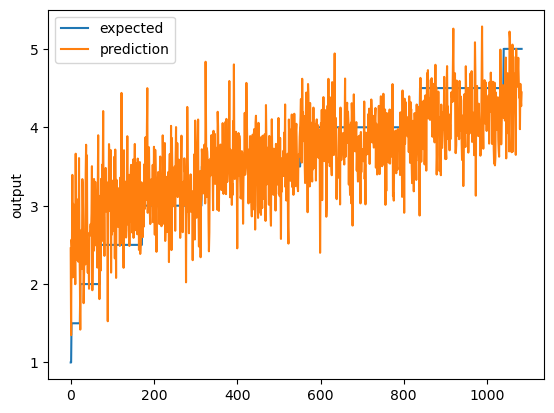

In [17]:
''' 
Tuning the following hyperparameters when training neural networks using Tensorflow and
tabulate all the results of each model on how they affect performance in your report. Also,
save all the models you have tried as a proof in your notebook.
• Activation: relu, sigmoid, tanh
• Number of layers and neuron count for each layer
• Optimizer: adam and sgd. 
'''

from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

model_dir = "models"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Set path and preprocess for functions
path = "./yelp_dataset/"

#Set paths for JSON
review_Path = os.path.join(path,"yelp_academic_dataset_review.json")
business_Path = os.path.join(path,"yelp_academic_dataset_business.json")

# Read JSON data and drop businesses with less than 20 reviews
review_df = pd.read_json(review_Path, lines=True, nrows = 100000)
all_business_df = pd.read_json(business_Path, lines=True, nrows = 100000)
business_df = all_business_df[all_business_df['review_count'] >= 20]

#You may use the following code to group ALL the reviews by each business and create a new
#dataframe, where each line is a business with all its reviews aggregated together. From there,
#you then use tfidfVectorzier to obtain TFIDF representation for each business.
df_review_agg = review_df.groupby('business_id')['text'].sum()
df_ready_to_be_sent_to_sklearn = pd.DataFrame({'business_id': df_review_agg.index,
                                               'all_reviews': df_review_agg.values,})

#Create table with ID, stars, and all reviews in one table then change 'stars' since this is already a col on tfidf
business_subset = business_df[['business_id', 'stars']]
review_subset = df_ready_to_be_sent_to_sklearn[['business_id', 'all_reviews']]
merged_df = pd.merge(business_subset, df_ready_to_be_sent_to_sklearn, on='business_id', how='inner')
merged_df.rename(columns={'stars': 'stars_for_model'}, inplace=True)

# Initialize the tfidf Vectorizer and set max features and stop words
tfidf = TfidfVectorizer(max_features=4000,stop_words="english")

# Transform all_reviews and turn into a matrix
tfidf_matrix = tfidf.fit_transform(merged_df['all_reviews'])

# Turn the matrix into a dataframe where the cols are all the words. Then add the stars into the dataframe for model to use and use to_xy for tensorflow to read
tfidf_df = pd.DataFrame(data = tfidf_matrix.toarray(), columns = tfidf.get_feature_names_out())
tfidf_df = pd.concat([merged_df['stars_for_model'], tfidf_df] , axis=1)
x,y = to_xy(tfidf_df,'stars_for_model')

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

# Define hyperparameters that were requested
activations = ['relu', 'sigmoid', 'tanh']
layer_neurons = [[100, 50, 25], [150, 75, 30], [100, 100, 100]]  # Different layer configurations
optimizers = ['adam', 'sgd']

def Model_Test(activation, layer_neurons, optimizer):
    model = Sequential()
    model.add(Dense(layer_neurons[0], input_dim=x_train.shape[1], activation=activation))
    model.add(Dropout(0.1))
    for n in layer_neurons[1:]:
        model.add(Dense(n, activation=activation))
        model.add(Dropout(0.1))
    model.add(Dense(1, activation ='linear'))
    model.compile(loss='mean_squared_error', optimizer = optimizer)
    return model

results = []

for activation in activations:
    for neurons in layer_neurons:
        for optimizer in optimizers:
            model = Model_Test(activation, neurons, optimizer)

            #
            monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto')
            model_filename = f"model_{activation}_{neurons}_{optimizer}.keras"
            checkpointer = ModelCheckpoint(filepath=model_filename, verbose=0, save_best_only=True) # save best model

            # batch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32.
            model.fit(x_train,y_train,validation_data=(x_test,y_test), batch_size= 32, callbacks=[monitor,checkpointer],verbose=2,epochs=1000)

            #
            model.load_weights(model_filename)

            # Predict and measure RMSE
            pred = model.predict(x_test)
            print(pred)
            score = np.sqrt(metrics.mean_squared_error(pred,y_test))
            print("Score (RMSE): {}".format(score))

            # Store results
            results.append({
                'Activation': activation,
                'Neurons': str(neurons),
                'Optimizer': optimizer,
                'RMSE': score
            })

# Table of Results
results_df = pd.DataFrame(results)
print(results_df)

# Plot the chart
best_model = model
pred = best_model.predict(x_test)
chart_regression(pred.flatten(), y_test)